In [1]:
from gad_adversarial_robustness.poison.greedy import multiple_AS
from gad_adversarial_robustness.utils.graph_utils import prepare_graph
import numpy as np
import torch.nn as nn
import torch


class OddBall_AS(nn.Module):
    def __init__(self, n_node, device):
        """
            target_lst (numpy.ndarray): The target list to be initialized.
            n_node (int): The number of nodes.  
            device (str): The device to be used.
        """
        super().__init__()
        self.n = n_node
        self.device = device
    
    def adjacency_matrix(self, tri):
        A = torch.sparse_coo_tensor(tri[:,:2].T, tri[:,2], size=[self.n,self.n]).to_dense()
        A = A + A.T - torch.diag(torch.diag(A)) # symmetric.
        return A
    
    def sparse_matrix_power(self, A, tau):
        A_sp = A.to_sparse()
        A_sp = torch.sparse_coo_tensor(A_sp.indices(), A_sp.values(), size=[self.n,self.n])
        return torch.sparse.mm(torch.sparse.mm(A_sp, A_sp), A_sp).to_dense()
    
    def extract_NE(self, A):    # Extract node and edge information based on adjecency matrix
        N = torch.sum(A, 1)
        E = torch.sum(A, 1) + 0.5 * torch.diag(self.sparse_matrix_power(A, 3)).T
        N = N.reshape(-1,1)
        E = E.reshape(-1,)
        return N, E
    
    def OLS_estimation(self, N, E):
        """
        OLS estimation function that calculates the Ordinary Least Squares estimate.
        
        Parameters:
            N (tensor): Input tensor for independent variable N
            E (tensor): Input tensor for dependent variable E
        
        Returns:
            tensor: Tensor result of the OLS estimation
        """
        logN = torch.log(N + 1e-20)
        logE = torch.log(E + 1e-20)
        logN1 = torch.cat((torch.ones((len(logN),1)).to(self.device), logN), 1)
        return torch.linalg.pinv(logN1) @ logE
        
    def forward(self, tri): # Calculate the loss function / How much the output deviates from expected least squares estimate
        A = self.adjacency_matrix(tri)
        N, E = self.extract_NE(A)
        theta = self.OLS_estimation(N, E)
        b = theta[0] # Intercept
        w = theta[1] # Coefficient
        tmp = 0.
        for i in range(len(self.lst)):
            tmp += (torch.exp(b) * (N[self.lst[i]]**w) - E[self.lst[i]])**2 # Accumulate squared difference between expected (b * N[i]**w) and actual E[i]
        return tmp
    
    def true_AS(self, tri): # Calculate the true anomaly score by using OLS (Page 3 https://arxiv.org/pdf/2106.09989.pdf)
        # Originally from https://www.cs.cmu.edu/~christos/courses/826.F11/CMU-ONLY/oddball.pdf
        # Or https://www.researchgate.net/profile/Leman-Akoglu/publication/220894884_OddBall_Spotting_Anomalies_in_Weighted_Graphs/links/0fcfd50b2ea00b30d2000000/OddBall-Spotting-Anomalies-in-Weighted-Graphs.pdf

        A = self.adjacency_matrix(tri)
        N, E = self.extract_NE(A)
        theta = self.OLS_estimation(N, E)
        b = theta[0] # Intercept
        w = theta[1] # Coefficient
        tmp = 0.

        AS_list = []    

        for i in range(self.n):

            tmp = (torch.max(E[i],torch.exp(b)*(N[i]**w))\
                   /torch.min(E[i],torch.exp(b)*(N[i]**w)))*\
                    torch.log(torch.abs(E[i]-torch.exp(b)*(N[i]**w))+1)
            AS_list.append(tmp.item())
        return AS_list 


def get_OddBall_AS(data, device):
    _, adj, _ = prepare_graph(data) #Get adjacency matrix

    amount_of_nodes = data.num_nodes

    # 'triple' is a list that will store the perturbed triples during the poisoning process.
    # Each triple represents an edge modification in the form of (node1, node2, edge_label).

    dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges
    
    triple = []
    for i in range(amount_of_nodes):
        for j in range(i + 1, amount_of_nodes):
            triple.append([i, j, dense_adj[i,j]])  #Fill with 0, then insert actual after

    triple = np.array(triple)

    model = OddBall_AS(target_lst = None, n_node = amount_of_nodes, device = device)

    OddBall_AS = model.true_AS(triple)

    return OddBall_AS



In [3]:
#Dataset Stuff

from pygod.generator import gen_contextual_outlier, gen_structural_outlier

from torch_geometric.datasets import AttributedGraphDataset
from typing import List

string = "Cora"
#string = "Wiki"
#string = "Facebook"

dataset = AttributedGraphDataset(root = "data/"+string, name = string)

data = dataset[0]


amount_of_nodes = data.x.shape[0]

seed = None
num_nodes_to_inject = round(amount_of_nodes * 0.05)
num_nodes_per_clique = 10
num_cliques = round((num_nodes_to_inject / 2) / num_nodes_per_clique)
num_contextual_outliers = num_nodes_to_inject - num_cliques * num_nodes_per_clique

print(num_nodes_to_inject)
print(num_cliques)
print(num_contextual_outliers)

data, ya = gen_contextual_outlier(data, n = num_contextual_outliers, k = 50, seed = seed) 
#n (int) – Number of nodes converting to outliers.
#k (int) – Number of candidate nodes for each outlier node.

data, ys = gen_structural_outlier(data, m = num_nodes_per_clique, n = num_cliques, seed = seed)
#m (int) - Number nodes in the outlier cliques.
#n (int) - Number of outlier clique
data.y = torch.logical_or(ys, ya).long()
y_binary: List[int] = data.y.bool()
anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide



135
7
65


In [4]:
from pygod.utils import load_data
import copy
from typing import Tuple, List, Any


data = load_data("inj_cora")
y_binary: List[int] = data.y.bool()
print(y_binary)

anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide



_, adj, _ = prepare_graph(data) #Get adjacency matrix

amount_of_nodes = data.num_nodes

# 'triple' is a list that will store the perturbed triples during the poisoning process.
# Each triple represents an edge modification in the form of (node1, node2, edge_label).

dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges

triple = []
for i in range(amount_of_nodes):
    for j in range(i + 1, amount_of_nodes):
        triple.append([i, j, dense_adj[i,j]])  #Fill with 0, then insert actual after

triple = np.array(triple)



tensor([False, False, False,  ..., False, False, False])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=11054, density=0.15%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])


In [5]:
device = 'cpu'

model = OddBall_AS(n_node = amount_of_nodes, device = device)

AS_OddBall = model.true_AS(triple)

print(AS_OddBall)


C:\Users\grace\AppData\Local\Temp\ipykernel_14084\728218210.py:27: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse.mm(torch.sparse.mm(A_sp, A_sp), A_sp).to_dense()
C:\Users\grace\AppData\Local\Temp\ipykernel_14084\728218210.py:31: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  E = torch.sum(A, 1) + 0.5 * torch.diag(self.sparse_matrix_power(A, 3)).T


[0.10752671119173718, 0.8252248966765965, 1.7560447807381852, 0.0011201542863961782, 2.8481613100058962, 0.10752671119173718, 0.39922104121880597, 0.0011201542863961782, 0.8252248966765965, 0.6338922711981417, 0.3578943867118035, 0.6338922711981417, 1.1280333298841374, 0.3578943867118035, 0.5677399085065261, 3.052505617110166, 1.3011776164150752, 0.28946367030386244, 1.7560447807381852, 0.0011201542863961782, 0.28946367030386244, 0.3578943867118035, 1.7805703576628513, 0.0011201542863961782, 1.7171327984302163, 1.3011776164150752, 2.8481613100058962, 0.39922104121880597, 0.0011201542863961782, 0.3578943867118035, 1.5121548264829443, 0.0011201542863961782, 1.3011776164150752, 1.3359273080385727, 0.0011201542863961782, 1.750274582810047, 0.08949664567350181, 0.8252248966765965, 0.39922104121880597, 1.9571135921672864, 0.8252248966765965, 1.782813228896842, 0.3578943867118035, 0.888859702154658, 0.10752671119173718, 0.888859702154658, 0.3578943867118035, 0.3578943867118035, 2.750768938854

In [4]:
def get_DOMINANT_AS(DOMINANT_model, config):
    
    DOMINANT_model.to(config['model']['device'])
    DOMINANT_model.fit(config, verbose=False)

    return DOMINANT_model.score


In [6]:

import yaml
import os
#from torch_sparse import SparseTensor

from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_torch_sparse_tensor

script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..', 'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')

if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'


clean_data: Data = load_data("inj_cora", dataset_caching_path)
poisoned_data: Data = load_data("inj_cora", dataset_caching_path)

dataset: Data = load_data("inj_cora")
adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])

#edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
#attrs = torch.FloatTensor(attrs)

edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])


sparse_adj = to_torch_sparse_tensor(edge_index)

dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)




In [6]:
DOMINANT_AS = get_DOMINANT_AS(dom_model, config)

print(DOMINANT_AS)

False False
False False
False


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False Fals

In [11]:
from gad_adversarial_robustness.poison.greedy import greedy_attack_with_statistics

amount_of_nodes = data.num_nodes
model_AS = multiple_AS(target_lst = anomaly_list, n_node = amount_of_nodes, device = 'cpu')


list_of_doms = []
list_of_doms.append(dom_model)
list_of_doms.append(dom_model)
triple_torch, AS, list_of_AS_DOM, list_of_AUC_DOM, list_of_ACC_DOM, perturb, edge_index = greedy_attack_with_statistics(model_AS, triple, list_of_doms, config, anomaly_list, 2, print_stats = True)




False False
False False
False


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False Fals

c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False Fals

c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False Fals

c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False Fals

c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False Fals

c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False False
False False
False
False Fals

In [10]:
print(AS)
print(list_of_AUC_DOM)

print(list_of_AS_DOM)

[350.96286245 346.69877033 341.24061807]
[[0.8194806293351379, 0.8176450685163255, 0.8215445779055998]]
[[140.44505, 139.28558, 139.63391]]


In [10]:
print(AS)

print(list_of_AUC_DOM)



[350.96286245 346.69877033 341.24061807]
[[0.7741470704336546, 0.7651835560818813, 0.7421502283877517], [0.7441239496983026, 0.7520639485704617, 0.749097727400891]]


In [81]:

k = 300

sorted_dom_as = np.argsort(DOMINANT_AS)[::-1]
sorted_odd_as = np.argsort(AS_OddBall)[::-1]

print(sorted_dom_as[:k])
print(sorted_odd_as[:k])

topK_dom = sorted_dom_as[:k]
topK_odd = sorted_odd_as[:k]

topK_all = list(set(topK_dom).union(set(topK_odd)))

indexes_dom = []
indexes_odd = []

indexes_dom_anom = []
indexes_odd_anom = []


for i in topK_all:
    if i in anomaly_list:
        indexes_dom_anom.append(np.where(sorted_dom_as == i)[0][0])
        indexes_odd_anom.append(np.where(sorted_odd_as == i)[0][0])
    else :
        indexes_dom.append(np.where(sorted_dom_as == i)[0][0])
        indexes_odd.append(np.where(sorted_odd_as == i)[0][0])



print(topK_all)
print(indexes_dom)
print(indexes_odd)

#I want to get the indexes of the nodes, in each list

[1358 1986 1701  306 1810 1623 2034 1013   88 1072 1914 1169  733 1224
  598  109 2045 1725 2155 1229  657 1042 1131 1441 1542  415  539  151
  833 1235  459  118 1035 1416 1483 2182  436 1367   95  973  963 1015
  124 1624  661 2450  687 2001  310 1765 1309 1103  429 1740  441 1135
 1628  454 1692 2359 1703 2394 1973  702 1894 2056 1742 1133  734  711
 2624  915  456  143 1732 1950 2291  581  239 2367 1826 1927 2600 1505
 2238  565 2025 1090  843  525 2198  299   55 2130  279  438 2358  645
 1655  698  350  738 1901   94 1533   73  572 2654 2451 1776 1362 2248
 1317 2671 1966  154  218 2365  505 2307  577 2518  747 1351 2386  311
  869  519 1257  641 2126  181 2083 2177 1682  170 1869 1674  210  507
 1310 1050 1952  781 1785 1540 1583 1171 1154 1912  287 1287  451  487
 2383 1570 1206   65  277 2122  155  980   76  938 2121  364  180 1256
 2089 1702  748 1842 2078 1426 1119   59  831 1958 1783 1957 1902 1530
 2080 1681 1602 1573 2227  294  867 2199 2475  490  236   33  482  695
 1053 

Dominant's anomalies within top 500 nodes: 93
OddBall's anomalies within top 500 nodes: 76


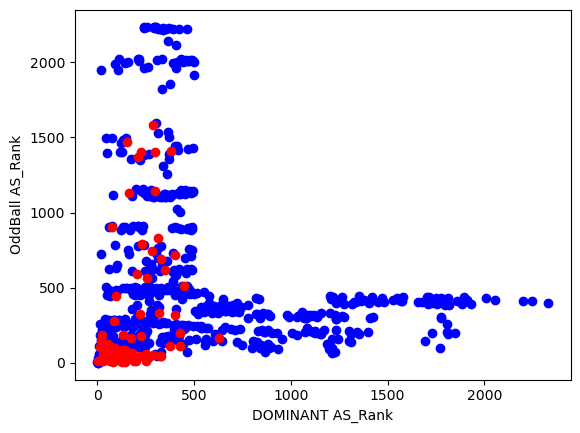

In [80]:
import matplotlib.pyplot as plt

anomaly_list = np.where(dom_model.label == True)[0]  # Used for list for which nodes to hide

#print(anomaly_list)

print("Dominant's anomalies within top "+ str(k) +" nodes:",len(set(topK_dom).intersection(set(anomaly_list))))
print("OddBall's anomalies within top "+ str(k) +" nodes:",len(set(topK_odd).intersection(set(anomaly_list))))

plt.plot(indexes_dom, indexes_odd, 'o', color = 'blue')
plt.plot(indexes_dom_anom, indexes_odd_anom, 'o', color = 'red')
plt.xlabel('DOMINANT AS_Rank')
plt.ylabel('OddBall AS_Rank')
plt.show()


In [6]:
import argparse
import os
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
#from torch_sparse import SparseTensor


class multiple_AS(nn.Module):
    def __init__(self, target_lst, n_node, device):
        """
            target_lst (numpy.ndarray): The target list to be initialized.
            n_node (int): The number of nodes.  
            device (str): The device to be used.
        """
        super().__init__()
        self.lst = target_lst
        self.n = n_node
        self.device = device
    
    def adjacency_matrix(self, tri):
        A = torch.sparse_coo_tensor(tri[:,:2].T, tri[:,2], size=[self.n,self.n]).to_dense()
        A = A + A.T - torch.diag(torch.diag(A)) # symmetric.
        return A
    
    def sparse_matrix_power(self, A, tau):
        A_sp = A.to_sparse()
        A_sp = torch.sparse_coo_tensor(A_sp.indices(), A_sp.values(), size=[self.n,self.n])
        return torch.sparse.mm(torch.sparse.mm(A_sp, A_sp), A_sp).to_dense()
    
    def extract_NE(self, A):    # Extract node and edge information based on adjecency matrix
        N = torch.sum(A, 1)
        E = torch.sum(A, 1) + 0.5 * torch.diag(self.sparse_matrix_power(A, 3)).T
        N = N.reshape(-1,1)
        E = E.reshape(-1,)
        return N, E
    
    def OLS_estimation(self, N, E):
        """
        OLS estimation function that calculates the Ordinary Least Squares estimate.
        
        Parameters:
            N (tensor): Input tensor for independent variable N
            E (tensor): Input tensor for dependent variable E
        
        Returns:
            tensor: Tensor result of the OLS estimation
        """
        logN = torch.log(N + 1e-20)
        logE = torch.log(E + 1e-20)
        logN1 = torch.cat((torch.ones((len(logN),1)).to(self.device), logN), 1)
        return torch.linalg.pinv(logN1) @ logE
        
    def forward(self, tri): # Calculate the loss function / How much the output deviates from expected least squares estimate
        A = self.adjacency_matrix(tri)
        N, E = self.extract_NE(A)
        theta = self.OLS_estimation(N, E)
        b = theta[0] # Intercept
        w = theta[1] # Coefficient
        tmp = 0.
        for i in range(len(self.lst)):
            tmp += (torch.exp(b) * (N[self.lst[i]]**w) - E[self.lst[i]])**2 # Accumulate squared difference between expected (b * N[i]**w) and actual E[i]
        return tmp
    
    def true_AS(self, tri): # Calculate the true anomaly score by using OLS (Page 3 https://arxiv.org/pdf/2106.09989.pdf)
        # Originally from https://www.cs.cmu.edu/~christos/courses/826.F11/CMU-ONLY/oddball.pdf
        # Or https://www.researchgate.net/profile/Leman-Akoglu/publication/220894884_OddBall_Spotting_Anomalies_in_Weighted_Graphs/links/0fcfd50b2ea00b30d2000000/OddBall-Spotting-Anomalies-in-Weighted-Graphs.pdf

        A = self.adjacency_matrix(tri)
        N, E = self.extract_NE(A)
        theta = self.OLS_estimation(N, E)
        b = theta[0] # Intercept
        w = theta[1] # Coefficient
        tmp = 0.
        for i in range(len(self.lst)):
            tmp += (torch.max(E[self.lst[i]],torch.exp(b)*(N[self.lst[i]]**w))\
                   /torch.min(E[self.lst[i]],torch.exp(b)*(N[self.lst[i]]**w)))*\
                    torch.log(torch.abs(E[self.lst[i]]-torch.exp(b)*(N[self.lst[i]]**w))+1)
        return tmp

def poison_attack(model, triple, B, print_stats = False):
    triple_copy = triple.copy()
    print(f'triple copy type: {type(triple_copy)}')
    triple_torch = Variable(torch.from_numpy(triple_copy), requires_grad = True) 
    AS = []
    perturb = []
    AS.append(model.true_AS(triple_torch).data.numpy()[0])
    if(print_stats): print('initial anomaly score:', model.true_AS(triple_torch).data.numpy()[0])
    
    for i in range(1,B+1):
        loss = model.forward(triple_torch)
        loss.backward()
        
        tmp = triple_torch.grad.data.numpy() # Get gradient of tensor with respect to data, stored in tmp


        grad = np.concatenate((triple_torch[:,:2].data.numpy(),tmp[:,2:]),1) # Concat edge descriptor with gradients
        

        v_grad = np.zeros((len(grad),3))

        for j in range(len(grad)):
            v_grad[j,0] = grad[j,0]
            v_grad[j,1] = grad[j,1]
            if triple_copy[j,2] == 0 and grad[j,2] < 0: # If no edge and gradient is negative
                v_grad[j,2] = grad[j,2]
            elif triple_copy[j,2] == 1 and grad[j,2] > 0: # If edge and gradient is positive
                v_grad[j,2] = grad[j,2]
            else:
                continue

        # Get indexes of sorted gradients in descending order [3,1,2]->[1,2,0]
        v_grad = v_grad[np.abs(v_grad[:,2]).argsort()] 
        

        # attack w.r.t gradient information.
        K = -1

        # Takes the edge with largest gradient by using neg K value(last k element)and finds the first that isn't already changed
        # Thusly changing the edge with the highest value
        while v_grad[K][:2].astype('int').tolist() in perturb:
            K -= 1

        #print(v_grad[K])
        
        # for count in range(10):
        #     print(v_grad[K-count])
            
            
        # do not delete edge from singleton.
        while v_grad[int(K)][2] > 0 and \
             (model.adjacency_matrix(triple_torch).data.numpy()[int(v_grad[int(K)][0])].sum() <= 1 or \
              model.adjacency_matrix(triple_torch).data.numpy()[int(v_grad[int(K)][1]) ].sum() <= 1):
            K -= 1
        
        target_grad = v_grad[int(K)] #Picks edge to target

        # Get index of target in triple
        target_index = np.where(np.all((triple[:,:2] == target_grad[:2]), axis = 1) == True)[0][0]

        # Update representation of adjacency matrix (triple_torch)
        triple_copy[target_index,2] -= np.sign(target_grad[2])
        #triple_torch = Variable(torch.from_numpy(triple_copy), requires_grad = True)

        # Add perturb to list of perturbs
        perturb.append([int(target_grad[0]),int(target_grad[1]), int(0 < target_grad[2])]) 

        # Get updated anomaly score
        # if print_stats:
        #     true_AScore = model.true_AS(triple_torch).data.numpy()[0] 
        #     print('iter', i, 'anomaly score:', true_AScore)

        print('iter', i, "perturb:", v_grad[K]) # Temp

    #AS = np.array(AS)    

    sparse_tensor = triple_torch.to_sparse()

    return triple_torch, AS, perturb

from pygod.detector import DOMINANT
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, adj_matrix_sparse_coo_to_dense
from gad_adversarial_robustness.utils.experiment_results import Experiment
import torch
from pygod.utils import load_data
import copy
from typing import Tuple, List, Any

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score
)

In [7]:
from torch.optim.sgd import SGD
from torch.optim.optimizer import required
from torch.optim import Optimizer
import torch
import sklearn
import numpy as np
import scipy.sparse as sp

In [9]:
data = load_data("inj_cora")
y_binary: List[int] = data.y.bool()
print(y_binary)

anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide
print(anomaly_list)

detector = DOMINANT(hid_dim=64, num_layers=4, epoch=100)
detector.fit(data)

pred, score, prob, conf = detector.predict(data,
                                    return_pred=True,
                                    return_score=True,
                                    return_prob=True,
                                    return_conf=True)
experiment_before_poison = Experiment(data=data, pred=pred, prob=prob, score=score, conf=conf)

_, adj, _ = prepare_graph(data)


# 'triple' is a list that will store the perturbed triples during the poisoning process.
# Each triple represents an edge modification in the form of (node1, node2, edge_label).

dense_adj = adj.to_dense()  #Fill in zeroes where there are no edges




tensor([False, False, False,  ..., False, False, False])
[  10   50   70   76  104  124  127  143  151  170  179  181  196  214
  217  224  227  287  289  294  311  333  425  438  451  454  459  539
  565  572  578  581  615  619  641  652  654  660  670  674  692  711
  722  738  781  833  843  869  874  878  882  891  895  915  923  938
  980  982  996 1002 1014 1035 1053 1079 1090 1096 1133 1135 1206 1211
 1224 1229 1235 1287 1293 1310 1362 1391 1414 1426 1533 1540 1543 1547
 1570 1573 1575 1606 1623 1633 1656 1674 1728 1730 1732 1783 1808 1818
 1833 1854 1881 1885 1901 1918 1946 1999 2004 2041 2052 2055 2056 2078
 2089 2121 2126 2198 2215 2234 2263 2265 2294 2307 2336 2340 2375 2382
 2386 2397 2475 2479 2506 2518 2551 2600 2624 2654 2658 2693]
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,  

In [10]:
np_dense_adj = np.array(dense_adj)
print("Create poison compatible adjacency matrix...")
triple = []
for i in range(amount_of_nodes):
    for j in range(i + 1, amount_of_nodes):
        triple.append([i, j, np_dense_adj[i,j]])  #Fill with 0, then insert actual after

triple = np.array(triple)

Create poison compatible adjacency matrix...


NameError: name 'amount_of_nodes' is not defined

In [11]:

target_list = anomaly_list
print(target_list)

[  10   50   70   76  104  124  127  143  151  170  179  181  196  214
  217  224  227  287  289  294  311  333  425  438  451  454  459  539
  565  572  578  581  615  619  641  652  654  660  670  674  692  711
  722  738  781  833  843  869  874  878  882  891  895  915  923  938
  980  982  996 1002 1014 1035 1053 1079 1090 1096 1133 1135 1206 1211
 1224 1229 1235 1287 1293 1310 1362 1391 1414 1426 1533 1540 1543 1547
 1570 1573 1575 1606 1623 1633 1656 1674 1728 1730 1732 1783 1808 1818
 1833 1854 1881 1885 1901 1918 1946 1999 2004 2041 2052 2055 2056 2078
 2089 2121 2126 2198 2215 2234 2263 2265 2294 2307 2336 2340 2375 2382
 2386 2397 2475 2479 2506 2518 2551 2600 2624 2654 2658 2693]


In [12]:

print("Making model...")
model = multiple_AS(target_lst = target_list, n_node = amount_of_nodes, device = 'cpu')

budget = target_list.shape[0] * 2  # The amount of edges to change

budget = 20
print("Starting attack...")

adj_adversary, AS, perturb = poison_attack(model, triple, budget, print_stats = True)


Making model...


NameError: name 'amount_of_nodes' is not defined

In [13]:
print(perturb)

[[151, 843, 1], [641, 2600, 1]]


In [5]:
#Testing area
edge_index = data.edge_index # Get a copy of original

for change in perturb:
    if (change[2] == 1):    #If to add edge
        edge_index = torch.cat((edge_index, torch.tensor([[change[0], change[1]], [change[1], change[0]]])), -1)
    else:   #Delete edge

        for i in reversed(range(edge_index.size(dim = 1))):   #Cycle through all edges in reverse, if matches delete
            if ((edge_index[0][i] == change[0] and edge_index[1][i] == change[1]) or
                (edge_index[0][i] == change[1] and edge_index[1][i] == change[0])):
                edge_index = torch.cat((edge_index[:, :i], edge_index[:, i+1:]), axis = 1)


NameError: name 'perturb' is not defined

In [82]:


edge_index = torch.load('edge_index_after_poison276.pt')

# Make new data object with new edge index
data_after_poison = copy.deepcopy(data)
edge_index = edge_index.type(torch.int64)
data_after_poison.edge_index = edge_index

print("Running model on poisoned data...")

detector_poisoned = DOMINANT(hid_dim=64, num_layers=4, epoch=100)
detector_poisoned.fit(data_after_poison)

pred_after, score_after, prob_after, conf_after = detector_poisoned.predict(data_after_poison,
                                    return_pred=True,
                                    return_score=True,
                                    return_prob=True,
                                    return_conf=True)
experiment_after_poison = Experiment(data=data_after_poison, pred=pred_after, score=score_after, prob=prob_after, conf=conf_after)


Running model on poisoned data...


In [13]:

import yaml
import os
import torch
#from torch_sparse import SparseTensor

from gad_adversarial_robustness.gad.dominant.dominant import Dominant 
from gad_adversarial_robustness.utils.graph_utils import load_anomaly_detection_dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_torch_sparse_tensor

script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..', 'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

dataset_caching_path = os.path.join(script_dir, '..', '..', '..', 'data')

if torch.cuda.is_available():
    config['model']['device'] = 'cuda'
else:
    config['model']['device'] = 'cpu'


clean_data: Data = load_data("inj_cora", dataset_caching_path)
poisoned_data: Data = load_data("inj_cora", dataset_caching_path)

dataset: Data = load_data("inj_cora")
adj, _, _, adj_label = load_anomaly_detection_dataset(clean_data, config['model']['device'])
#edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
#attrs = torch.FloatTensor(attrs)

edge_index = dataset.edge_index.to(config['model']['device'])
label = torch.Tensor(dataset.y.bool()).to(config['model']['device'])
attrs = dataset.x.to(config['model']['device'])


sparse_adj = to_torch_sparse_tensor(edge_index)

print("Before poison:")
dom_model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)


Before poison:


In [14]:
testingModel = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)
testingModel.to(config['model']['device'])
testingModel.fit(config, verbose=False)


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:64: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  src = src.to_sparse_csr()


Epoch: 0199, Auc: 0.8239609767100885
Top 10 highest anomaly scores' node IDs and scores:
Node ID: 1358, Anomaly Score: 3.0948009490966797
Node ID: 1986, Anomaly Score: 2.6128649711608887
Node ID: 1701, Anomaly Score: 2.4250082969665527
Node ID: 306, Anomaly Score: 2.2346243858337402
Node ID: 1623, Anomaly Score: 2.136927366256714
Node ID: 1810, Anomaly Score: 2.1242728233337402
Node ID: 2034, Anomaly Score: 2.0249013900756836
Node ID: 1013, Anomaly Score: 1.9403607845306396
Node ID: 1072, Anomaly Score: 1.8863722085952759
Node ID: 88, Anomaly Score: 1.883890151977539


In [15]:
def target_node_mask(target_list, tuple_list):
    new_list = []
    for index in target_list:
        new_list.append(tuple_list[index])
    
    t = torch.tensor(new_list)

    return t



In [9]:
#Teting yayy

from statistics import mean

#Hypothesis: Anomalies will have unnatural weights
def compareWeights(model, anomaly_nodes):
    """
        Takes the attributes of each node and compares it with the weights the fitted model assigns

        model: a fitted model
        anomaly_nodes: the nodes which could be different from the rest

        returns:
            - List of effect a node has after 1st layer
            - List of effect a node has after 2nd layer
            - List of effect an anomaly has after 1st layer
            - List of effect an anomaly has after 2nd layer
    """
    weights1 = model.shared_encoder.gc1.lin.weight
    weights2 = model.shared_encoder.gc2.lin.weight

    attries = model.attrs

    layer1_scores = []
    layer2_scores = []
    layer1_scores_anom = []
    layer2_scores_anom = []

    # Add for layer 1
    for i, nodeatr in enumerate(attries):
        result = torch.matmul(weights1, nodeatr)
        layer1_scores.append(np.sum(result.detach().numpy()))

        if(i in anomaly_nodes):
            layer1_scores_anom.append(np.sum(result.detach().numpy()))

    # Add for layer 2
        result = torch.matmul(weights2, result)
        layer2_scores.append(np.sum(result.detach().numpy()))

        if(i in anomaly_nodes):
            layer2_scores_anom.append(np.sum(result.detach().numpy()))
    
    return layer1_scores, layer2_scores, layer1_scores_anom, layer2_scores_anom



l1_sc, l2_sc, l1_sc_anom, l2_sc_anom = compareWeights(testingModel, target_list)



In [9]:
# Hypothesis, anomalies will have neighbors with unnatural scores. 
# Therefore by getting the accumulated score of neighbors there should be a pattern

from gad_adversarial_robustness.utils.subgraphs import get_subset_neighbors


def compareNeighborWeights(model, anomaly_nodes):

    # Get scores 
    l1_sc, l2_sc, l1_sc_anom, l2_sc_anom = compareWeights(testingModel, target_list)

    new_l1_sc = []
    new_l2_sc = []
    new_l1_sc_anom = []
    new_l2_sc_anom = []

    # Get edges
    edge_index = model.edge_index.indices().detach().cpu()

    #For each node
    for i in range(len(l1_sc)):
        # get neighbors
        neighbors = get_subset_neighbors(torch.tensor([i]), edge_index)
        result_layer1 = 0
        result_layer2 = 0
        
        #Get accumulated weigths
        for index in neighbors:
            result_layer1 += l1_sc[index]
            result_layer2 += l2_sc[index]
        
        new_l1_sc.append(result_layer1)
        new_l2_sc.append(result_layer2)
        
        if(i in anomaly_nodes):
            new_l1_sc_anom.append(result_layer1)
            new_l2_sc_anom.append(result_layer2)

    return new_l1_sc, new_l2_sc, new_l1_sc_anom, new_l2_sc_anom
            




l1_sc, l2_sc, l1_sc_anom, l2_sc_anom = compareNeighborWeights(testingModel, target_list)


[3, 5, 4]


In [18]:

# Hypothesis: We can teach a neural network to try predict weights based on adjacency matrix

import torch.nn as nn

class CompareNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size),
            #nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def compareWeightsNN(model, anomaly_nodes, epochs = 200):
    # Get adjacency matrix
    edge_index = model.edge_index.detach().cpu()
    adj = edge_index.to_dense()

    # Get weights
    weights1 = model.shared_encoder.gc1.lin.weight.detach().cpu()
    weights2 = model.shared_encoder.gc2.lin.weight.detach().cpu()

    # Get NN sizes
    start = adj.size(dim=0)

    end = weights1.size(dim=0)
            
    print(adj.size(dim=0))
    print(end)

    print(weights1.size())
    print(weights2.size())

    # Create NN
    mediumSize = end * 3
    NNcompare = CompareNN(start, mediumSize, end)

    for i in range(epochs):
        pass
    
    



compareWeightsNN(testingModel, target_list)

2708
96
torch.Size([96, 1433])
torch.Size([96, 96])


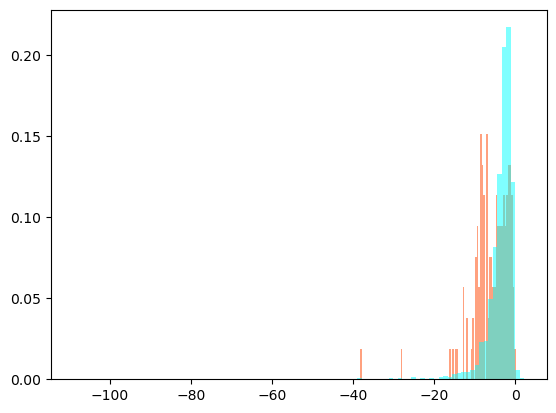

In [11]:
import matplotlib.pyplot as plt

plt.hist(l1_sc_anom, bins=100, color='orangered',  alpha = 0.5, density = True)
plt.hist(l1_sc, bins=100, color='cyan', alpha = 0.5, density = True)

plt.show()


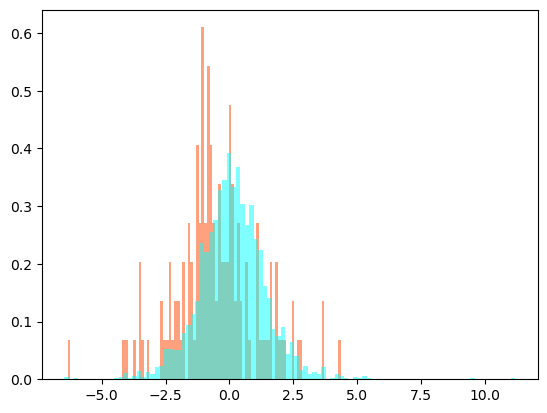

In [150]:

plt.hist(l2_sc_anom, bins=100, color='orangered',  alpha = 0.5, density = True)
plt.hist(l2_sc, bins=100, color='cyan', alpha = 0.5, density = True)

plt.show()

KeyboardInterrupt: 

In [98]:
# Hypothesis: It'll show after both layers

layer2 = testingModel.shared_encoder.gc2

weight2 = layer2.lin.weight

AS_Score2 = []

for nodeatr in attries:
    result = torch.matmul(weight, nodeatr)
    result = torch.matmul(weight2, result)
    AS_Score2.append(np.sum(result.detach().numpy()))

print(AS_Score2[target])
print(AS_Score2[target-5:target+5])
print(model_AS[target])
print(model_AS[target-5:target+5])




-1.0425442
[0.18837667, 5.237221, 0.22456044, 1.1749139, 1.2471384, -1.0425442, 0.5159174, 1.2365925, -1.0052723, 0.9963714]
1.0441806
[0.9194553  0.8097762  0.664796   1.0740165  0.64548194 1.0441806
 0.9445041  1.0325531  0.6730739  0.8200657 ]


tensor(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                       [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(2708, 2708), nnz=11054, layout=torch.sparse_coo)


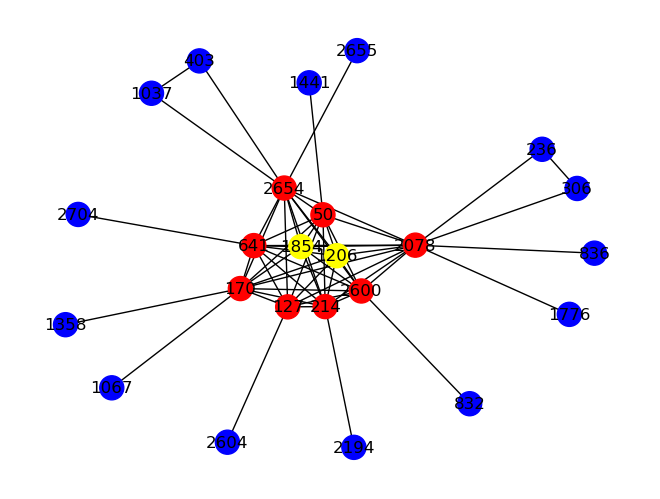

In [24]:
import networkx as nx
import torch_geometric.utils
from gad_adversarial_robustness.utils.subgraphs import get_subset_neighbors

def plot_graph(edge_index):
    """
    parameters:
        edge_index: sparse coo tensor with edge information

    produces a networkx graph
    """
    data = torch_geometric.data.Data(x=edge_index.values(), edge_index=edge_index.indices())

    g = torch_geometric.utils.to_networkx(data, to_undirected=True)

    nx.draw(g)


def plot_node_subgraph(edge_index, node_indexs, anomaly_list = [], with_labels = False):
    """
    parameters:
        edge_index: sparse coo tensor with edge information
        node_index: long tensor of node indices
        anomaly_list: list of anomaly nodes
        with_labels: boolean for whether to include labels

    produces a networkx graph
    """

    # Get neighbors
    neighbors = get_subset_neighbors(node_indexs, edge_index.indices())
    neighbors = torch.cat([neighbors, node_indexs])

    # Get subgraph
    subgraph = torch_geometric.utils.subgraph(neighbors, edge_index.indices(), edge_index.values())

    G = nx.Graph()
    transgraph = torch.transpose(subgraph[0], 0, 1).numpy()
    G.add_edges_from(transgraph)

    # plot
    color_map = []
    for node in G:
        if node in anomaly_list:
            if node in node_indexs:
                color_map.append('red')
            else:
                color_map.append('yellow')
        else:
            if node in node_indexs:
                color_map.append('green')
            else:
                color_map.append('blue') 

    nx.draw(G, node_color=color_map, with_labels=with_labels)

print

edge_data = testingModel.edge_index
indexs = torch.tensor([2654])
index = 6
indexs = torch.tensor(anomaly_list[index:index+1])
indexs = torch.tensor([641, 170, 127, 214, 2654, 2078, 2600, 50])
print(edge_data)
plot_node_subgraph(edge_data, indexs, anomaly_list = anomaly_list, with_labels = True)




In [1]:
indexs = torch.tensor(range(0, 11))
plot_node_subgraph(edge_data, indexs, anomaly_list = anomaly_list, with_labels = True)

NameError: name 'torch' is not defined

tensor(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                       [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(2708, 2708), nnz=11054, layout=torch.sparse_coo)
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
Flag 1
Flag 2
Flag 3


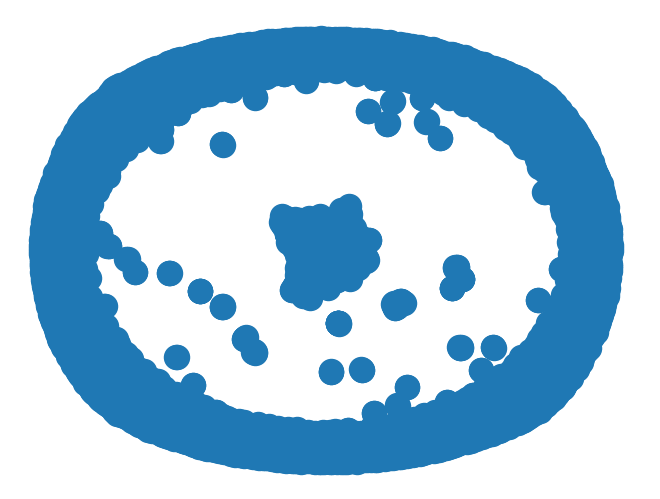

In [18]:
import matplotlib as plt
import networkx as nx
import torch_geometric.utils


edge_data = testingModel.edge_index


print(edge_data)
print(edge_data.indices())
print(edge_data.values())


print("Flag 1")

data = torch_geometric.data.Data(x=edge_data.values(), edge_index=edge_data.indices())
print("Flag 2")


g = torch_geometric.utils.to_networkx(data, to_undirected=True)
print("Flag 3")
nx.draw(g)



In [7]:

from gad_adversarial_robustness.poison.greedy import greedy_attack_with_statistics
print("Making model...")
model = multiple_AS(target_lst = target_list, n_node = amount_of_nodes, device = config['model']['device'])

budget = target_list.shape[0] * 2  # The amount of edges to change

budget = 10

print("Starting attack...")

_, AS, AS_DOM, AUC_DOM, ACC_DOM, perturb, edge_index = greedy_attack_with_statistics(
    model, triple, dom_model, config, target_list, budget, print_stats = True)



Making model...
Starting attack...


C:\Users\grace\AppData\Local\Temp\ipykernel_24152\3428229394.py:30: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse.mm(torch.sparse.mm(A_sp, A_sp), A_sp).to_dense()
C:\Users\grace\AppData\Local\Temp\ipykernel_24152\3428229394.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  E = torch.sum(A, 1) + 0.5 * torch.diag(self.sparse_matrix_power(A, 3)).T
c:\Users\grace\anaconda3\envs\Py

Epoch: 0199, Auc: 0.8251367506908024
initial anomaly score: 350.9628624456122


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.8097614616816107
iter 1 anomaly score: 346.6987703271884 DOM anomaly score: 2120.8608 DOM AUC: 0.8097614616816107 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7938504483166977
iter 2 anomaly score: 341.2406180708062 DOM anomaly score: 2099.4292 DOM AUC: 0.7938504483166977 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7779450741555292
iter 3 anomaly score: 337.3620232251917 DOM anomaly score: 2088.1182 DOM AUC: 0.7779450741555292 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7658574409293406
iter 4 anomaly score: 333.7385697175731 DOM anomaly score: 2078.8887 DOM AUC: 0.7658574409293406 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7518468392263011
iter 5 anomaly score: 329.50391797501845 DOM anomaly score: 2066.771 DOM AUC: 0.7518468392263011 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7492330682907572
iter 6 anomaly score: 325.39382010815854 DOM anomaly score: 2060.8792 DOM AUC: 0.7492330682907572 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7424265493712288
iter 7 anomaly score: 321.3425601986489 DOM anomaly score: 2059.2246 DOM AUC: 0.7424265493712288 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7302881633113405
iter 8 anomaly score: 317.5167619236698 DOM anomaly score: 2054.6055 DOM AUC: 0.7302881633113405 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7438645463260587
iter 9 anomaly score: 313.4219933045914 DOM anomaly score: 2056.3342 DOM AUC: 0.7438645463260587 TARGET DOM ACC: 0


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\torch_geometric\utils\_spmm.py:60: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Epoch: 0199, Auc: 0.7412366773811538
iter 10 anomaly score: 309.0142055763874 DOM anomaly score: 2050.1797 DOM AUC: 0.7412366773811538 TARGET DOM ACC: 0


In [26]:

def perturbStats(perturb, amomaly_list):
    """
        returns: 
            AtA_del_count: Anomaly to Anomaly deletion count
            AtA_add_count: Anomaly to Anomaly addition count
            AtN_del_count: Anomaly to Normal deletion count
            AtN_add_count: Anomaly to Normal addition count
            NtN_del_count: Normal to Normal deletion count
            NtN_add_count: Normal to Normal addition count

            del_dict: Dictionary of node indxs along with how often they have had deleted edges
            add_dict: Dictionary of node indxs along with how often they have had added edges
    """

    AtA_del_count = 0 #Anomaly to Anomaly deletion count
    AtA_add_count = 0 #Anomaly to Anomaly addition count
    AtN_del_count = 0 #Anomaly to Normal deletion count
    AtN_add_count = 0 #Anomaly to Normal addition count
    NtN_del_count = 0 #Normal to Normal deletion count
    NtN_add_count = 0 #Normal to Normal addition count

    del_dict = {}   # Dictionary of node indxs along with how often they have had deleted edges
    add_dict = {}   # Dictionary of node indxs along with how often they have had added edges
    
    def addToLib(index, dict_store):
        if index in dict_store:
            dict_store[index] += 1
        else:
            dict_store[index] = 1
    def addIndex(index, was_delete_action):
        if was_delete_action:
            addToLib(index, del_dict)
        else:
            addToLib(index, add_dict)

    for change in perturb:
        # Deletions
        if (change[0] in amomaly_list) and (change[1] in amomaly_list) and (change[2] == 1):
            AtA_del_count += 1
        elif ((change[0] in amomaly_list) and (change[1] not in amomaly_list) or 
            (change[0] not in amomaly_list) and (change[1] in amomaly_list)) and (change[2] == 1):
            AtN_del_count += 1
        elif (change[0] not in amomaly_list) and (change[1] not in amomaly_list) and (change[2] == 1):
            NtN_del_count += 1

        # Additions
        elif (change[0] in amomaly_list) and (change[1] in amomaly_list) and (change[2] == 0):
            AtA_del_count += 1
        elif ((change[0] in amomaly_list) and (change[1] not in amomaly_list) or 
            (change[0] not in amomaly_list) and (change[1] in amomaly_list)) and (change[2] == 0):
            AtN_del_count += 1
        elif (change[0] not in amomaly_list) and (change[1] not in amomaly_list) and (change[2] == 0):
            NtN_del_count += 1

        #Count up how often these nodes are deleted or added to
        addIndex(change[0], change[2])
        addIndex(change[1], change[2])
    
    return AtA_del_count, AtA_add_count, AtN_del_count, AtN_add_count, NtN_del_count, NtN_add_count, del_dict, add_dict
        

print(perturbStats(perturb, anomaly_list))




# indexs = torch.tensor(perturb[0][:2])
# plot_node_subgraph(edge_data, indexs, anomaly_list = anomaly_list, with_labels = True)

[(641, 2), (2600, 2), (2307, 2), (214, 2), (151, 1), (843, 1), (294, 1), (2518, 1), (124, 1), (1133, 1), (1310, 1), (1570, 1), (1674, 1), (980, 1), (1362, 1), (833, 1)]
{151: 1, 843: 1, 641: 2, 2600: 2, 294: 1, 2518: 1, 124: 1, 1133: 1, 1310: 1, 1570: 1, 1674: 1, 2307: 2, 980: 1, 1362: 1, 833: 1, 214: 2}
(10, 0, 0, 0, 0, 0, {151: 1, 843: 1, 641: 2, 2600: 2, 294: 1, 2518: 1, 124: 1, 1133: 1, 1310: 1, 1570: 1, 1674: 1, 2307: 2, 980: 1, 1362: 1, 833: 1, 214: 2}, {})


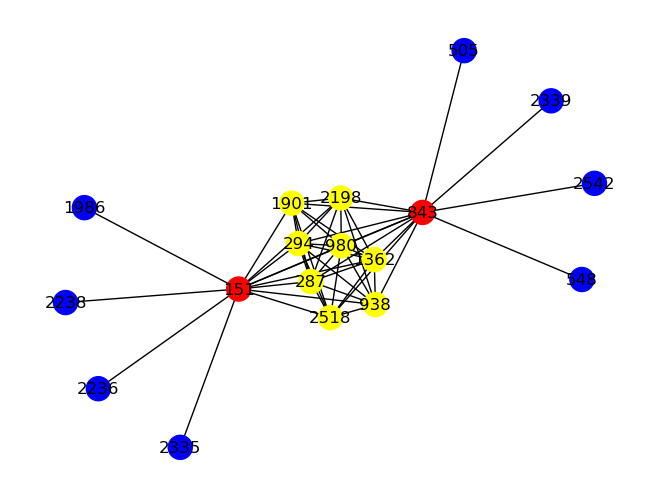

In [18]:
plot_node_subgraph(edge_index, indexs, anomaly_list = anomaly_list, with_labels = True)

In [132]:
print(model.edge_index)


def target_node_mask(target_list, tuple_list):
    new_list = []
    for index in target_list:
        new_list.append(tuple_list[index])
    
    t = torch.tensor(new_list)

    return t


print(model.label)

print(target_node_mask(target_list, model.label))


print(target_list)



print(f"Auc: {roc_auc_score(model.label, model.score)}")


print("After poison:")

edge_index = torch.load('edge_index_after_poison276.pt')


sparse_adj = to_torch_sparse_tensor(edge_index)
model = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                device=config['model']['device'], edge_index=sparse_adj, adj_label=adj_label, attrs=attrs, label=label)
model.to(config['model']['device'])
model.fit(config, verbose=False)



tensor(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                       [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(2708, 2708), nnz=11054, layout=torch.sparse_coo)
tensor([False, False, False,  ..., False, False, False])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, T

AttributeError: 'Dominant' object has no attribute 'score'

In [80]:
# torch.save(data_after_poison.edge_index, 'edge_index_after_poison.pt')


In [81]:
from torch_geometric.utils.mask import index_to_mask
from torch_geometric.utils.num_nodes import maybe_num_nodes

def getAvgScoreOfNeighbors(anomalyIndex, prob, data):

    edge_index = data.edge_index
    subset = torch.from_numpy(anomalyIndex)

    num_nodes = maybe_num_nodes(edge_index) # gets amount of nodes present in edges
    node_mask = index_to_mask(subset, size=num_nodes) # creates node mask

    edge_mask = node_mask[edge_index[0]] # create edge mask to find nodes starting from origin

    edge_index = edge_index[:, edge_mask] # apply mask

    neighbor_nodes = edge_index[1]  # get the edge destinations 

    #neighbor_nodes = torch.unique(neighbor_nodes)

    neighbor_nodes = neighbor_nodes.numpy()
    sum = 0
    anomaly_percent = 0
    len = neighbor_nodes.size
    for node in neighbor_nodes:

        #print("anomaly score for " + str(node) + " before poison: " + str(score[node].item()) + " after poison: " + str(score_after[node].item()))
        sum += prob[node].item()
        if(node in anomaly_list):
            anomaly_percent += 1


    return neighbor_nodes, sum/len, anomaly_percent/len

In [80]:



print("auc before poison:")
print(roc_auc_score(y_binary, score))
print("auc after poison:")
print(roc_auc_score(y_binary, score_after))
#print(roc_auc_score(data_inj.y.detach().numpy(), score_inj.detach.numpy()))

print("List of perturbed edges:")
print(perturb)
# Testing only for the targetted nodes
#for anomalyIndex in target_list:

    #print("pred score for " + str(anomalyIndex) + " before poison: " + str(prob[anomalyIndex].item()) + " after poison: " + str(prob_after[anomalyIndex].item()))







auc before poison:
0.7682428241132351
auc after poison:
0.571313370552078
List of perturbed edges:
[[0, 633, 0], [0, 1862, 0]]


In [40]:
tensor = torch.tensor(np.arange(data.num_nodes))

tensor2 = torch.max(torch.cat((tensor, tensor), dim=0)).item()

print(tensor2)

number = tensor[10]
print(number)

number = number + 10

print(tensor[number])

tens = torch.zeros(2,5)
print(tens)
tens = tens.numpy()
print(tens)





2707
tensor(10, dtype=torch.int32)
tensor(20, dtype=torch.int32)
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [83]:
from gad_adversarial_robustness.utils.subgraphs import get_subset_neighbors
from torch_geometric.utils.num_nodes import maybe_num_nodes

from matplotlib import pyplot as plt

def get_rest_of_node_idxs(subset_idxs, num_nodes):
    """
        Function to get the indices of the remaining nodes after removing the nodes specified in subset_idxs.

        - subset_idxs (tensor): The idxs of the nodes not to include.
        - num_nodes (int): The total number of nodes in the graph.

        Returns:
        A tensor containing all node idxs not in the subset
        """

    rest_of_node_idxs = torch.tensor(np.arange(num_nodes))

    for i in subset_idxs:
        rest_of_node_idxs = torch.cat([rest_of_node_idxs[0:i], rest_of_node_idxs[i+1:]])
    
    return rest_of_node_idxs

def visualize_local_degree_assortativity(edge_index_list, graph_names = None, cut_off = None):
    """
        Visualizes the cumulative distribution of local_degree_assortativity for a list of edge_indexes
        Parameters:
        - edge_index_list: List of edge indexes of the graphs
        - graph_names (list of str): The names of the graphs
        - cut_off (int): Limiter for amount of neighbors to display. Default none.

        Returns:
        No return value.
        """
    
    fig = plt.figure(figsize=(9, 4), layout="constrained")
    ax = fig.add_subplot(1, 1, 1)

    # For each subset....
    for i, edge_index in enumerate(edge_index_list):

        # Get amount of neighbors for each node
        num_nodes = maybe_num_nodes(edge_index)
        node_idxs = torch.tensor(np.arange(num_nodes))
        node_idxs_neighbors_amount = []

        # Find 
        for idx in node_idxs:
            neighbor_node = get_subset_neighbors(idx, edge_index)  #Get neighbors
            neighbor_degrees = np.array(get_subset_neighbors(neighbor_nodes[n], edge_index).size()[0] for n in range(neighbor_node.size()[0])) #Get degrees of neighbors

            average_degree = neighbor_degrees.mean()
            idx_degree = neighbor_nodes.size()[0]

            amount = neighbor_nodes.size()[0]   # Get amount
            amount = amount - 1 # Subtract self
            node_idxs_neighbors_amount.append(amount)

        # Name graph
        graph_name = 'graph' + str(i)
        if(graph_names is not None):
            graph_name = graph_names[i]
        ax.ecdf(node_idxs_neighbors_amount, label=graph_name)
        
   # Label figure
    fig.suptitle("Cumulative distribution of 2hop node degrees")

    ax.grid(True)
    ax.legend()
    ax.set_xlabel("2hop Node degree")
    ax.set_ylabel("Probability of occurrence")
    ax.label_outer()

    if(cut_off is not None):
        ax.set_xbound(0, cut_off)
            
    plt.show()





[3, 5, 4]


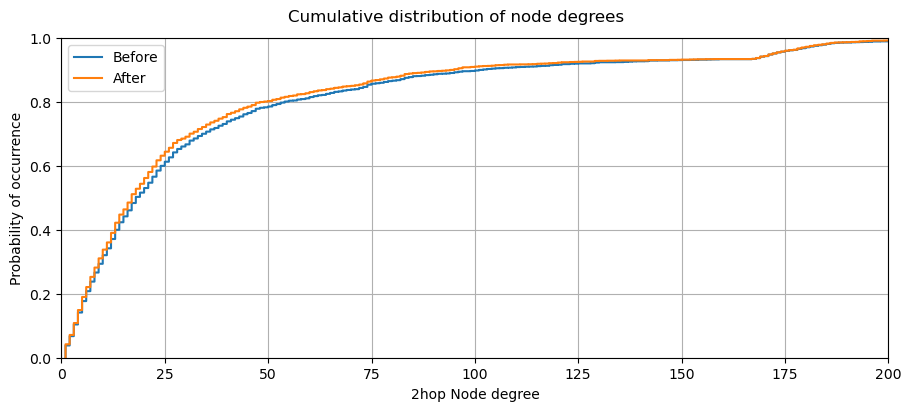

In [100]:


#from gad_adversarial_robustness.utils.visualizations import visualize_neighbors_amount

tensor_target = torch.from_numpy(target_list)

normalize = True
cut_off = 200

# visualize_neighbors_amount(data.edge_index, tensor_target, data.num_nodes, max_val=max_val, normalize=normalize)
# visualize_neighbors_amount(data_after_poison.edge_index, tensor_target, data_after_poison.num_nodes, max_val=max_val, normalize=normalize)


visualize_2hop_node_degree([data.edge_index, data_after_poison.edge_index], ["Before", "After"], cut_off = cut_off)


In [84]:
#Total of anomalies: 138


#my_list = target_list

my_list = torch.tensor(np.arange(data.num_nodes))

print(my_list.type)

for i in target_list:
    my_list = torch.cat([my_list[0:i], my_list[i+1:]])

my_list = my_list.numpy()

neighbor_nodes, avg, anomaly_percent = getAvgScoreOfNeighbors(my_list, prob, data)
print("amount of neighbors before: " + str(neighbor_nodes.size) + " avg before: " + str(avg) + " anomaly percent before: " + str(anomaly_percent))
#print("neighbor_nodes: " + str(neighbor_nodes))
print(anomaly_percent*neighbor_nodes.size)

neighbor_pure_nodes_clean = neighbor_nodes

neighbor_nodes, avg, anomaly_percent = getAvgScoreOfNeighbors(my_list, prob_after, data_after_poison)
print("amount of neighbors after: " + str(neighbor_nodes.size) + " avg after: " + str(avg) + " anomaly percent after: " + str(anomaly_percent))
#print("neighbor_nodes: " + str(neighbor_nodes))
print(anomaly_percent*neighbor_nodes.size)

neighbor_pure_nodes_poison = neighbor_nodes

print("For anomaliesss")
my_list = target_list

neighbor_nodes, avg, anomaly_percent = getAvgScoreOfNeighbors(my_list, prob, data)
print("amount of neighbors before: " + str(neighbor_nodes.size) + " avg before: " + str(avg) + " anomaly percent before: " + str(anomaly_percent))
#print("neighbor_nodes: " + str(neighbor_nodes))
print(anomaly_percent*neighbor_nodes.size)

neighbor_anom_nodes_clean = neighbor_nodes

neighbor_nodes, avg, anomaly_percent = getAvgScoreOfNeighbors(my_list, prob_after, data_after_poison)
print("amount of neighbors after: " + str(neighbor_nodes.size) + " avg after: " + str(avg) + " anomaly percent after: " + str(anomaly_percent))
#print("neighbor_nodes: " + str(neighbor_nodes))
print(anomaly_percent*neighbor_nodes.size)

neighbor_anom_nodes_poison = neighbor_nodes


length = len(target_list)

print("Avg neighbor pure clean", neighbor_pure_nodes_clean.size/(data.num_nodes - length), 
      "Avg neighbor pure poison", neighbor_pure_nodes_poison.size/(data.num_nodes - length))

print("Avg neighbor anom clean", neighbor_anom_nodes_clean.size/length, 
      "Avg neighbor anom poison", neighbor_anom_nodes_poison.size/length)




<built-in method type of Tensor object at 0x0000026E31788A90>
amount of neighbors before: 10524 avg before: 0.15594277257813216 anomaly percent before: 0.09492588369441277
999.0
amount of neighbors after: 9982 avg after: 0.14872725149463178 anomaly percent after: 0.050591063915047085
505.0
For anomaliesss
amount of neighbors before: 1034 avg before: 0.1865738933513367 anomaly percent before: 0.5222437137330754
540.0
amount of neighbors after: 532 avg after: 0.16427809229563514 anomaly percent after: 0.16165413533834586
86.0
Avg neighbor pure clean 4.094941634241245 Avg neighbor pure poison 3.884046692607004
Avg neighbor anom clean 7.492753623188406 Avg neighbor anom poison 3.8550724637681157


In [85]:
sum_found = 0
sum_prob = 0
for node in target_list:
    sum_found += pred[node]
    sum_prob += prob[node]

print("before...")
print("amount detected", sum_found, "accuracy:", sum_found/len(target_list), "total probability:", sum_prob, "avg_probability:", sum_prob/len(target_list))

sum_found = 0
sum_prob = 0
for node in target_list:
    sum_found += pred_after[node]
    sum_prob += prob_after[node]
    # if(pred_after[node] == 1):
    #     print(node)

print("after...")
print("amount detected", sum_found, "accuracy:", sum_found/len(target_list), "total probability:", sum_prob, "avg_probability:", sum_prob/len(target_list))




before...
amount detected tensor(69) accuracy: tensor(0.5000) total probability: tensor(19.9885) avg_probability: tensor(0.1448)
after...
amount detected tensor(14) accuracy: tensor(0.1014) total probability: tensor(11.7051) avg_probability: tensor(0.0848)


In [ ]:
#PPoison

from gad_adversarial_robustness.poison.greedy import inject_greedy_poison
from pygod.utils import load_data
from typing import List

data = load_data("inj_cora")
y_binary: List[int] = data.y.bool()

anomaly_list = np.where(y_binary == True)[0]


poison_data = inject_greedy_poison(data, anomaly_list, print_stats = True)
 



Create poison compatible adjacency matrix...
tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=11054, density=0.15%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])
Making model...
Starting attack...
triple copy type: <class 'numpy.ndarray'>


c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\gad_adversarial_robustness\poison\greedy.py:35: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse.mm(torch.sparse.mm(A_sp, A_sp), A_sp).to_dense()
c:\Users\grace\anaconda3\envs\PyG2\lib\site-packages\gad_adversarial_robustness\poison\greedy.py:39: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  E = torch.sum(A, 1) + 0.5 * torch.diag(

initial anomaly score: 350.9628624456122
iter 1 anomaly score: 346.6987703271884
iter 2 anomaly score: 341.2406180708062
iter 3 anomaly score: 337.3620232251917
iter 4 anomaly score: 333.7385697175731
iter 5 anomaly score: 329.50391797501845
iter 6 anomaly score: 325.39382010815854
iter 7 anomaly score: 321.3425601986489
iter 8 anomaly score: 317.5167619236698
iter 9 anomaly score: 313.4219933045914
iter 10 anomaly score: 309.0142055763874
iter 11 anomaly score: 305.7359028071064
iter 12 anomaly score: 301.8869749481308
iter 13 anomaly score: 298.3467216385668
iter 14 anomaly score: 294.59401804658097
iter 15 anomaly score: 291.56750593155715
iter 16 anomaly score: 287.87021106491227
iter 17 anomaly score: 284.2041540246569
iter 18 anomaly score: 280.13574147426374
iter 19 anomaly score: 275.6951718223874
iter 20 anomaly score: 270.8844996775314
iter 21 anomaly score: 266.837855182466
iter 22 anomaly score: 263.8609857542011
iter 23 anomaly score: 260.848587650538
iter 24 anomaly score

In [3]:
#Cleaninggg


class PGD(Optimizer):
    """Proximal gradient descent.

    Parameters
    ----------
    params : iterable
        iterable of parameters to optimize or dicts defining parameter groups
    proxs : iterable
        iterable of proximal operators
    alpha : iterable
        iterable of coefficients for proximal gradient descent
    lr : float
        learning rate
    momentum : float
        momentum factor (default: 0)
    weight_decay : float
        weight decay (L2 penalty) (default: 0)
    dampening : float
        dampening for momentum (default: 0)

    """

    def __init__(self, params, proxs, alphas, lr=required, momentum=0, dampening=0, weight_decay=0):
        defaults = dict(lr=lr, momentum=0, dampening=0,
                        weight_decay=0, nesterov=False)


        super(PGD, self).__init__(params, defaults)

        self.proxs = proxs
        self.alphas = alphas

        for group in self.param_groups:
            group.setdefault('proxs', proxs)
            group.setdefault('alphas', alphas)

    def __setstate__(self, state):
        super(PGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('proxs', self.proxs)   #Added self'
            group.setdefault('alphas', self.alphas) #Added self

    def step(self, delta=0, closure=None):
         for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            proxs = group['proxs']
            alphas = group['alphas']

            # apply the proximal operator to each parameter in a group
            for param in group['params']:
                for prox_operator, alpha in zip(proxs, alphas):
                    # param.data.add_(lr, -param.grad.data)
                    # param.data.add_(delta)
                    param.data = prox_operator(param.data, alpha=alpha*lr)



In [4]:

class ProxOperators():
    """Proximal Operators.
    """

    def __init__(self):
        self.nuclear_norm = None

    def prox_l1(self, data, alpha):
        """Proximal operator for l1 norm.
        """
        data = torch.mul(torch.sign(data), torch.clamp(torch.abs(data)-alpha, min=0))
        return data

    def prox_nuclear(self, data, alpha):
        """Proximal operator for nuclear norm (trace norm).
        """
        device = data.device
        U, S, V = np.linalg.svd(data.cpu())
        U, S, V = torch.FloatTensor(U).to(device), torch.FloatTensor(S).to(device), torch.FloatTensor(V).to(device)
        self.nuclear_norm = S.sum()
        # print("nuclear norm: %.4f" % self.nuclear_norm)

        diag_S = torch.diag(torch.clamp(S-alpha, min=0))
        return torch.matmul(torch.matmul(U, diag_S), V)

    def prox_nuclear_truncated_2(self, data, alpha, k=50):
        device = data.device
        import tensorly as tl
        tl.set_backend('pytorch')
        U, S, V = tl.truncated_svd(data.cpu(), n_eigenvecs=k)
        U, S, V = torch.FloatTensor(U).to(device), torch.FloatTensor(S).to(device), torch.FloatTensor(V).to(device)
        self.nuclear_norm = S.sum()
        # print("nuclear norm: %.4f" % self.nuclear_norm)

        S = torch.clamp(S-alpha, min=0)

        # diag_S = torch.diag(torch.clamp(S-alpha, min=0))
        # U = torch.spmm(U, diag_S)
        # V = torch.matmul(U, V)

        # make diag_S sparse matrix
        indices = torch.tensor((range(0, len(S)), range(0, len(S)))).to(device)
        values = S
        diag_S = torch.sparse.FloatTensor(indices, values, torch.Size((len(S), len(S))))
        V = torch.spmm(diag_S, V)
        V = torch.matmul(U, V)
        return V

    def prox_nuclear_truncated(self, data, alpha, k=50):
        device = data.device
        indices = torch.nonzero(data).t()
        values = data[indices[0], indices[1]] # modify this based on dimensionality
        data_sparse = sp.csr_matrix((values.cpu().numpy(), indices.cpu().numpy()))
        U, S, V = sp.linalg.svds(data_sparse, k=k)
        U, S, V = torch.FloatTensor(U).to(device), torch.FloatTensor(S).to(device), torch.FloatTensor(V).to(device)
        self.nuclear_norm = S.sum()
        diag_S = torch.diag(torch.clamp(S-alpha, min=0))
        return torch.matmul(torch.matmul(U, diag_S), V)

    def prox_nuclear_cuda(self, data, alpha):

        device = data.device
        U, S, V = torch.svd(data)
        # self.nuclear_norm = S.sum()
        # print(f"rank = {len(S.nonzero())}")
        self.nuclear_norm = S.sum()
        S = torch.clamp(S-alpha, min=0)
        indices = torch.tensor([range(0, U.shape[0]),range(0, U.shape[0])]).to(device)
        values = S
        diag_S = torch.sparse.FloatTensor(indices, values, torch.Size(U.shape))
        # diag_S = torch.diag(torch.clamp(S-alpha, min=0))
        # print(f"rank_after = {len(diag_S.nonzero())}")
        V = torch.spmm(diag_S, V.t_())
        V = torch.matmul(U, V)
        return V


In [5]:


class SGD(Optimizer):


    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

In [6]:
prox_operators = ProxOperators()


In [7]:
def accuracy(output, labels):
    """Return accuracy of output compared to labels.

    Parameters
    ----------
    output : torch.Tensor
        output from model
    labels : torch.Tensor or numpy.array
        node labels

    Returns
    -------
    float
        accuracy
    """
    if not hasattr(labels, '__len__'):
        labels = [labels]
    if type(labels) is not torch.Tensor:
        labels = torch.LongTensor(labels)
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double() #Checks equality of predictions and labels
    correct = correct.sum()
    return correct / len(labels)

In [8]:
# Code for pro-gnn

import time
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings

In [9]:
class EstimateAdj(nn.Module):
    """Provide a pytorch parameter matrix for estimated
    adjacency matrix and corresponding operations.
    """

    def __init__(self, adj, symmetric=False, device='cpu'):
        super(EstimateAdj, self).__init__()
        n = len(adj)
        self.estimated_adj = nn.Parameter(torch.FloatTensor(n, n))
        self._init_estimation(adj)
        self.symmetric = symmetric
        self.device = device

    def _init_estimation(self, adj):
        with torch.no_grad():
            n = len(adj)
            self.estimated_adj.data.copy_(adj)

    def forward(self):
        return self.estimated_adj

    def normalize(self):

        if self.symmetric:
            adj = (self.estimated_adj + self.estimated_adj.t())/2
        else:
            adj = self.estimated_adj

        normalized_adj = self._normalize(adj + torch.eye(adj.shape[0]).to(self.device))
        return normalized_adj

    def _normalize(self, mx):
        rowsum = mx.sum(1)
        r_inv = rowsum.pow(-1/2).flatten()
        r_inv[torch.isinf(r_inv)] = 0.
        r_mat_inv = torch.diag(r_inv)
        mx = r_mat_inv @ mx
        mx = mx @ r_mat_inv
        return mx

In [10]:

class ProGNN:
    """ ProGNN (Properties Graph Neural Network). See more details in Graph Structure Learning for Robust Graph Neural Networks, KDD 2020, https://arxiv.org/abs/2005.10203.

    Parameters
    ----------
    model:
        model: The backbone GNN model in ProGNN
    args:
        model configs
    device: str
        'cpu' or 'cuda'.

    Examples
    --------
    See details in https://github.com/ChandlerBang/Pro-GNN.

    """

    def __init__(self, model, args, device):
        self.device = device
        self.args = args
        self.best_val_acc = 0
        self.best_val_loss = 10
        self.best_graph = None
        self.weights = None
        self.estimator = None
        self.model = model.to(device)

    def fit(self, features, adj, labels, idx_train, idx_val, **kwargs):
        """Train Pro-GNN.

        Parameters
        ----------
        features :
            node features
        adj :
            the adjacency matrix. The format could be torch.tensor or scipy matrix
        labels :
            node labels
        idx_train :
            node training indices
        idx_val :
            node validation indices
        """
        args = self.args

        self.optimizer = optim.Adam(self.model.parameters(),
                               lr=args.lr, weight_decay=args.weight_decay)
        estimator = EstimateAdj(adj, symmetric=args.symmetric, device=self.device).to(self.device)
        self.estimator = estimator
        self.optimizer_adj = optim.SGD(estimator.parameters(),
                              momentum=0.9, lr=args.lr_adj)

        self.optimizer_l1 = PGD(estimator.parameters(),
                        proxs=[prox_operators.prox_l1],
                        lr=args.lr_adj, alphas=[args.alpha])

        # warnings.warn("If you find the nuclear proximal operator runs too slow on Pubmed, you can  uncomment line 67-71 and use prox_nuclear_cuda to perform the proximal on gpu.")
        # if args.dataset == "pubmed":
        #     self.optimizer_nuclear = PGD(estimator.parameters(),
        #               proxs=[prox_operators.prox_nuclear_cuda],
        #               lr=args.lr_adj, alphas=[args.beta])
        # else:
        warnings.warn("If you find the nuclear proximal operator runs too slow, you can modify line 77 to use prox_operators.prox_nuclear_cuda instead of prox_operators.prox_nuclear to perform the proximal on GPU. See details in https://github.com/ChandlerBang/Pro-GNN/issues/1")
        self.optimizer_nuclear = PGD(estimator.parameters(),
                  proxs=[prox_operators.prox_nuclear],
                  lr=args.lr_adj, alphas=[args.beta])

        # Train model
        t_total = time.time()
        for epoch in range(args.epochs):
            if args.only_gcn:
                self.train_gcn(epoch, features, estimator.estimated_adj,
                        labels, idx_train, idx_val)
            else:
                for i in range(int(args.outer_steps)):
                    self.train_adj(epoch, features, adj, labels,
                            idx_train, idx_val)

                for i in range(int(args.inner_steps)):
                    self.train_gcn(epoch, features, estimator.estimated_adj,
                            labels, idx_train, idx_val)

        print("Optimization Finished!")
        print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
        print(args)

        # Testing
        print("picking the best model according to validation performance")
        self.model.load_state_dict(self.weights)

    def train_gcn(self, epoch, features, adj, labels, idx_train, idx_val):
        args = self.args
        estimator = self.estimator
        adj = estimator.normalize()

        t = time.time()
        self.model.train()
        self.optimizer.zero_grad()

        output = self.model(features, adj)
        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        self.optimizer.step()

        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        self.model.eval()
        output = self.model(features, adj)

        loss_val = F.nll_loss(output[idx_val], labels[idx_val])
        acc_val = accuracy(output[idx_val], labels[idx_val])

        if acc_val > self.best_val_acc:
            self.best_val_acc = acc_val
            self.best_graph = adj.detach()
            self.weights = deepcopy(self.model.state_dict())
            if args.debug:
                print('\t=== saving current graph/gcn, best_val_acc: %s' % self.best_val_acc.item())

        if loss_val < self.best_val_loss:
            self.best_val_loss = loss_val
            self.best_graph = adj.detach()
            self.weights = deepcopy(self.model.state_dict())
            if args.debug:
                print(f'\t=== saving current graph/gcn, best_val_loss: %s' % self.best_val_loss.item())

        if args.debug:
            if epoch % 1 == 0:
                print('Epoch: {:04d}'.format(epoch+1),
                      'loss_train: {:.4f}'.format(loss_train.item()),
                      'acc_train: {:.4f}'.format(acc_train.item()),
                      'loss_val: {:.4f}'.format(loss_val.item()),
                      'acc_val: {:.4f}'.format(acc_val.item()),
                      'time: {:.4f}s'.format(time.time() - t))



    def train_adj(self, epoch, features, adj, labels, idx_train, idx_val):
        estimator = self.estimator
        args = self.args
        if args.debug:
            print("\n=== train_adj ===")
        t = time.time()
        estimator.train()
        self.optimizer_adj.zero_grad()

        loss_l1 = torch.norm(estimator.estimated_adj, 1)
        loss_fro = torch.norm(estimator.estimated_adj - adj, p='fro')
        normalized_adj = estimator.normalize()

        if args.lambda_:
            loss_smooth_feat = self.feature_smoothing(estimator.estimated_adj, features)
        else:
            loss_smooth_feat = 0 * loss_l1

        output = self.model(features, normalized_adj)
        loss_gcn = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])

        loss_symmetric = torch.norm(estimator.estimated_adj \
                        - estimator.estimated_adj.t(), p="fro")

        loss_diffiential =  loss_fro + args.gamma * loss_gcn + args.lambda_ * loss_smooth_feat + args.phi * loss_symmetric

        loss_diffiential.backward()

        self.optimizer_adj.step()
        loss_nuclear =  0 * loss_fro
        if args.beta != 0:
            self.optimizer_nuclear.zero_grad()
            self.optimizer_nuclear.step()
            loss_nuclear = prox_operators.nuclear_norm

        self.optimizer_l1.zero_grad()
        self.optimizer_l1.step()

        total_loss = loss_fro \
                    + args.gamma * loss_gcn \
                    + args.alpha * loss_l1 \
                    + args.beta * loss_nuclear \
                    + args.phi * loss_symmetric

        estimator.estimated_adj.data.copy_(torch.clamp(
                  estimator.estimated_adj.data, min=0, max=1))

        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        self.model.eval()
        normalized_adj = estimator.normalize()
        output = self.model(features, normalized_adj)

        loss_val = F.nll_loss(output[idx_val], labels[idx_val])
        acc_val = accuracy(output[idx_val], labels[idx_val])
        print('Epoch: {:04d}'.format(epoch+1),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val.item()),
              'time: {:.4f}s'.format(time.time() - t))

        if acc_val > self.best_val_acc:
            self.best_val_acc = acc_val
            self.best_graph = normalized_adj.detach()
            self.weights = deepcopy(self.model.state_dict())
            if args.debug:
                print(f'\t=== saving current graph/gcn, best_val_acc: %s' % self.best_val_acc.item())

        if loss_val < self.best_val_loss:
            self.best_val_loss = loss_val
            self.best_graph = normalized_adj.detach()
            self.weights = deepcopy(self.model.state_dict())
            if args.debug:
                print(f'\t=== saving current graph/gcn, best_val_loss: %s' % self.best_val_loss.item())

        if args.debug:
            if epoch % 1 == 0:
                print('Epoch: {:04d}'.format(epoch+1),
                      'loss_fro: {:.4f}'.format(loss_fro.item()),
                      'loss_gcn: {:.4f}'.format(loss_gcn.item()),
                      'loss_feat: {:.4f}'.format(loss_smooth_feat.item()),
                      'loss_symmetric: {:.4f}'.format(loss_symmetric.item()),
                      'delta_l1_norm: {:.4f}'.format(torch.norm(estimator.estimated_adj-adj, 1).item()),
                      'loss_l1: {:.4f}'.format(loss_l1.item()),
                      'loss_total: {:.4f}'.format(total_loss.item()),
                      'loss_nuclear: {:.4f}'.format(loss_nuclear.item()))


    def test(self, features, labels, idx_test):
        """Evaluate the performance of ProGNN on test set
        """
        print("\t=== testing ===")
        self.model.eval()
        adj = self.best_graph
        if self.best_graph is None:
            adj = self.estimator.normalize()
        output = self.model(features, adj)
        loss_test = F.nll_loss(output[idx_test], labels[idx_test])
        acc_test = accuracy(output[idx_test], labels[idx_test])
        print("\tTest set results:",
              "loss= {:.4f}".format(loss_test.item()),
              "accuracy= {:.4f}".format(acc_test.item()))
        return acc_test.item()

    def feature_smoothing(self, adj, X):
        adj = (adj.t() + adj)/2
        rowsum = adj.sum(1)
        r_inv = rowsum.flatten()
        D = torch.diag(r_inv)
        L = D - adj

        r_inv = r_inv  + 1e-3
        r_inv = r_inv.pow(-1/2).flatten()
        r_inv[torch.isinf(r_inv)] = 0.
        r_mat_inv = torch.diag(r_inv)
        # L = r_mat_inv @ L
        L = r_mat_inv @ L @ r_mat_inv

        XLXT = torch.matmul(torch.matmul(X.t(), L), X)
        loss_smooth_feat = torch.trace(XLXT)
        return loss_smooth_feat

In [11]:
# Use model
from gad_adversarial_robustness.gad.dominant.dominant import Dominant
from gad_adversarial_robustness.utils.graph_utils import prepare_graph
model = Dominant()


#perturbed_adj, features, labels = preprocess(perturbed_adj, features, labels, preprocess_adj=False, device=device)


node_attr, adj, labels = prepare_graph(poison_data)

prognn = ProGNN(model, args, device)
prognn.fit(node_attr, adj, labels, idx_train, idx_val)

prognn.test(node_attr, labels, idx_test)

['c:\\Users\\grace\\GitHub\\AAU-Dat6-Poison-GAD\\Defence', 'c:\\Users\\grace\\anaconda3\\envs\\PyG2\\python39.zip', 'c:\\Users\\grace\\anaconda3\\envs\\PyG2\\DLLs', 'c:\\Users\\grace\\anaconda3\\envs\\PyG2\\lib', 'c:\\Users\\grace\\anaconda3\\envs\\PyG2', '', 'c:\\Users\\grace\\anaconda3\\envs\\PyG2\\lib\\site-packages', 'c:\\Users\\grace\\anaconda3\\envs\\PyG2\\lib\\site-packages\\win32', 'c:\\Users\\grace\\anaconda3\\envs\\PyG2\\lib\\site-packages\\win32\\lib', 'c:\\Users\\grace\\anaconda3\\envs\\PyG2\\lib\\site-packages\\Pythonwin', 'c:\\Users\\grace\\GitHub\\AAU-Dat6-Poison-GAD\\learning\\learning_Dominant', 'c:\\Users\\grace\\GitHub\\AAU-Dat6-Poison-GAD\\learning\\learning_Dominant']


NameError: name 'GCN' is not defined

In [ ]:
prognn = ProGNN(model, args, device)

In [ ]:

prognn.fit(node_attr, adj, labels, idx_train, idx_val)
prognn.test(node_attr, labels, idx_test)

In [ ]:
prognn.test(node_attr, labels, idx_test)